In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset


In [2]:
figformat = 'svg'

In [3]:
import json
with open("../config.json") as json_data_file:
    config = json.load(json_data_file)
case = config['case']
config = config[case]
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]

models = Models.read(f"{path_crab}/standard_model.yml")
dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')

dataset_load = dataset_load.downsample(4)
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    




#dataset_load= dataset_load.slice_by_energy ( 0.3 *u.TeV, 3*u.TeV)

models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

{'path': '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset', 'path_crab': '../Crab'}
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


In [4]:
edispKernelMap = dataset_load.edisp
edispKernel = edispKernelMap.get_edisp_kernel()
edispMap = edispKernelMap.edisp_map

In [5]:
from astropy.visualization import quantity_support

def plot(edispKernel_, ax=None, label_true_energy = True):
    ax = plt.gca() if ax is None else ax
    kwargs =dict()
    kwargs.setdefault("cmap", "GnBu")
    from matplotlib.colors import PowerNorm

    norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)
    kwargs.setdefault("norm", norm)


    energy_axis = edispKernel.axes["energy"]
    if label_true_energy:
        energy_axis_true_ = edispKernel.axes["energy_true"]
    else:
        energy_axis_true_ = edispKernel.axes["energy"]

    with quantity_support():
        caxes = ax.pcolormesh(
            energy_axis_true_.edges, energy_axis.edges, edispKernel_.data.T, **kwargs
        )

    label = "Probability density (A.U.)"
    ax.figure.colorbar(caxes, ax=ax, label=label)

    energy_axis_true_.format_plot_xaxis(ax=ax)
    energy_axis.format_plot_yaxis(ax=ax)
    return ax

(24, 24)


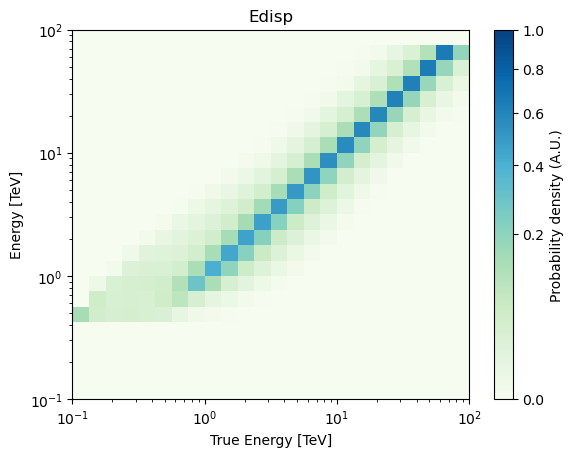

In [34]:
ax = plot(edispKernel)
ax.set_title(f'Edisp')
print(edispKernel.data.shape)
fig = plt.gcf()
fig.savefig("plots/2-Edisp_example.svg")

In [7]:
energy = edispKernel.axes['energy']
energy_true = edispKernel.axes['energy_true']

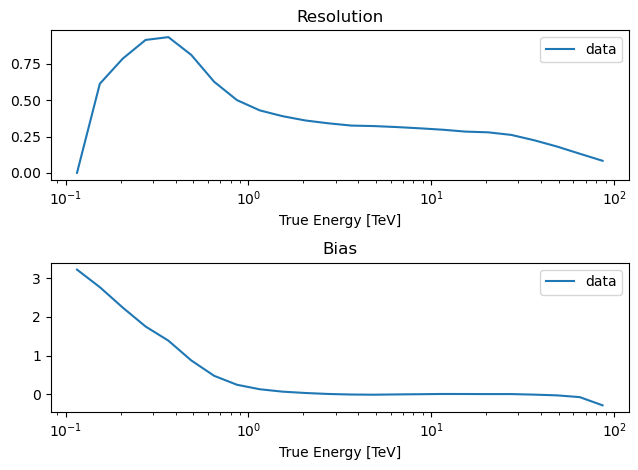

In [33]:
fig, axs = plt.subplots(2,1)

axs[0].plot(energy.center.value, edispKernel.get_resolution(energy.center), label = 'data')
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_title("Resolution")
axs[0].set_xlabel('True Energy [TeV]')


plt.plot(energy.center.value, edispKernel.get_bias(energy.center), label = 'data')
plt.legend()
plt.xscale('log')
plt.title("Bias")
plt.xlabel('True Energy [TeV]')
plt.tight_layout()
fig.savefig("plots/2-Edisp_res_bias.svg")

In [9]:
from gammapy.maps import MapAxis
from gammapy.irf import EDispKernel, EDispKernelMap
def get_gaussian_kernel(bias, sigma, energy = energy):
    edisp_kernel = EDispKernel.from_gauss(
        energy_axis_true=energy.copy(name='energy_true'), 
        energy_axis=energy,
        sigma=1e-12+sigma,
        bias=bias
    )
    return edisp_kernel

b= 0.0 s= 1e-12
(24, 24)
b= 0.0 s= 0.01
(24, 24)
b= 0.0 s= 0.5
(24, 24)
b= 0.0 s= 0.8
(24, 24)
(24, 24)


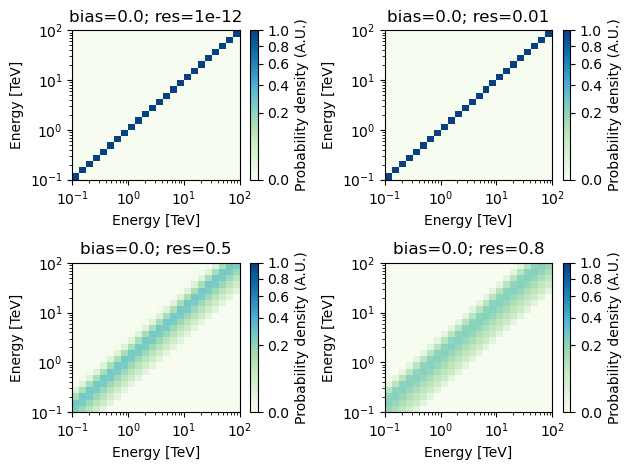

In [10]:


fig, axs = plt.subplots(2,2)
axs = axs.flatten()
delta = 1e-2
biass = [0.0]
sigmass = [0, 0.1, 0.5, 0.8]
sigmass = [1e-12, 1e-2, 0.5, 0.8]
#sigmass = [0.01, 0.02, 0.03, 0.04]
gaussians = []
i = 0

for b in biass:
    for s in sigmass:
        print("b=", b, "s=", s)
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        print(gaussian.data.shape)
        gaussians.append(gaussian)
        plot(gaussian,axs[i], False)
        axs[i].set_title(f'bias={b}; res={s}')
        i +=1
print(gaussian.data.shape)
plt.tight_layout()



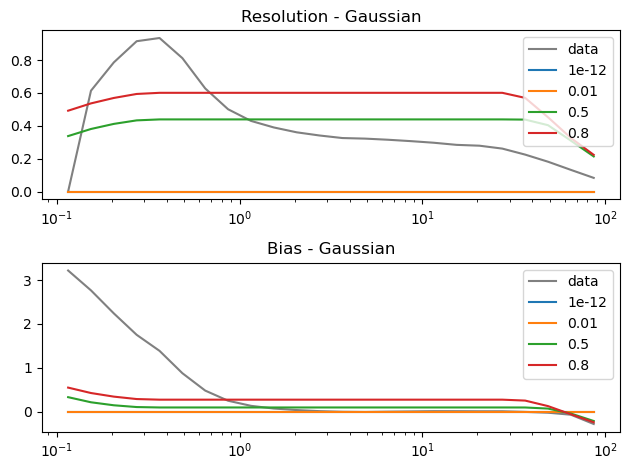

In [11]:
fig, axs = plt.subplots(2,1)

axs[0].plot(energy.center.value, edispKernel.get_resolution(energy.center), label = 'data',
           color = 'grey')
for i, c in enumerate(gaussians):
    axs[0].plot(energy.center.value, c.get_resolution(energy.center), label = sigmass[i])
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_title("Resolution - Gaussian")


plt.plot(energy.center.value, edispKernel.get_bias(energy.center), label = 'data',
        color = 'grey')
for i, c in enumerate(gaussians):
    plt.plot(energy.center.value, c.get_bias(energy.center), label = sigmass[i])
plt.legend()
plt.xscale('log')
plt.title("Bias - Gaussian")
plt.tight_layout()


(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)


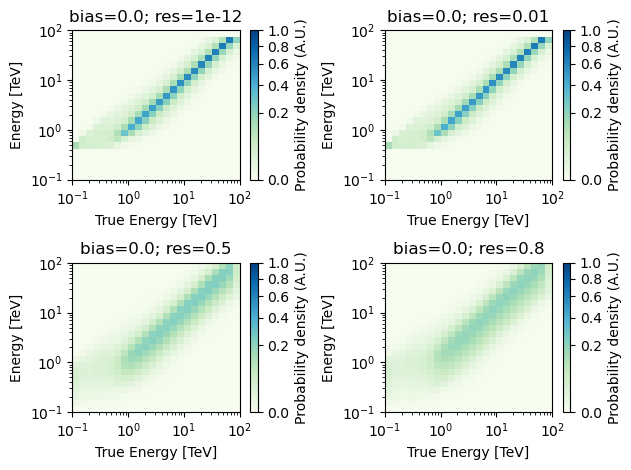

In [12]:
convs = []
fig, axs = plt.subplots(2,2)
axs = axs.flatten()

i = 0

for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        print(edispKernel.data.shape)
        print(gaussian.data.shape)
        
        conv = EDispKernel(
         axes = edispKernel.axes,
         data = np.matmul(edispKernel.data, gaussian.data)
        )
        plot(conv,axs[i])
        axs[i].set_title(f'bias={b}; res={s}')
        i +=1
        convs.append(conv)
plt.tight_layout()



Text(0.5, 1.0, 'Bias')

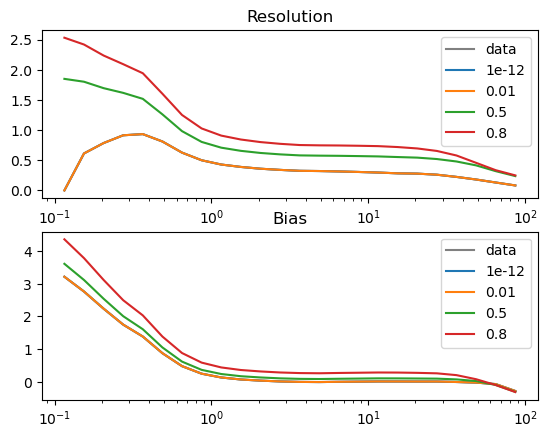

In [13]:
fig, axs = plt.subplots(2,1)

axs[0].plot(energy.center.value, edispKernel.get_resolution(energy.center), label = 'data',
           color = 'grey')
for i, c in enumerate(convs):
    axs[0].plot(energy.center.value, c.get_resolution(energy.center), label = sigmass[i])
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_title("Resolution")


plt.plot(energy.center.value, edispKernel.get_bias(energy.center), label = 'data',
        color = 'grey')
for i, c in enumerate(convs):
    plt.plot(energy.center.value, c.get_bias(energy.center), label = sigmass[i])
plt.legend()
plt.xscale('log')
plt.title("Bias")

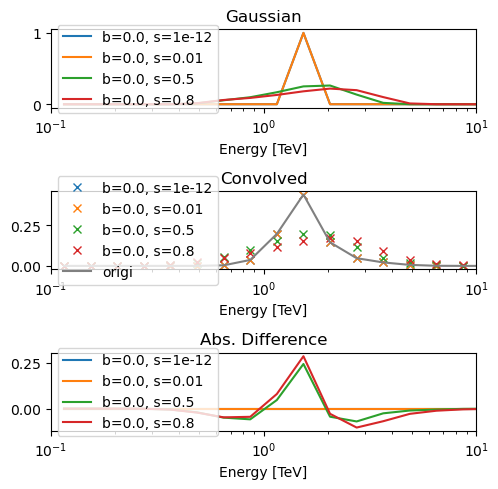

In [14]:
fig, axs = plt.subplots(3,1, figsize = (5,5))
idx = 9
for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        conv = EDispKernel( axes = edispKernel.axes,  data = np.matmul(edispKernel.data, gaussian.data))
        axs[0].plot(energy.center, gaussian.data[idx,:], label = f'b={b}, s={s}')
        axs[2].plot(energy.center , edispKernel.data[idx,:]-conv.data[idx,:], label = f'b={b}, s={s}')
        axs[1].plot(energy.center , conv.data[idx,:], 'x', label = f'b={b}, s={s}')
        
axs[1].plot(energy.center ,edispKernel.data[idx,:], label = 'origi', color = 'grey')
axs[0].set_title("Gaussian")
axs[1].set_title("Convolved")
axs[2].set_title("Abs. Difference")



for a in axs:
    a.legend(loc = 'center left')
    a.set_xlabel("Energy [TeV]")
    a.set_xscale('log')
    a.set_xlim(0.1, 10)
    
plt.tight_layout()

In [28]:
widths = (energy.edges[1:] - energy.edges[:-1]) * 0.5

conv_data = conv.data[idx,:] 
n_bins = 10
idx = 9
conv_rebins = np.repeat(conv_data, n_bins)
energy_rebins = MapAxis(nodes =np.logspace(np.log10(energy.edges[0].value), 
                                           np.log10(energy.edges[-1].value),
                                           n_bins *len(energy.center)),
                        node_type='center',
                        name = 'energy',
                       unit = 'TeV')

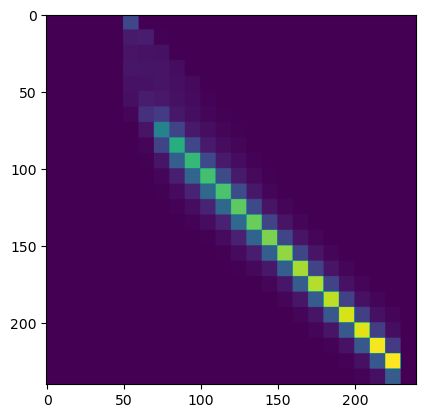

In [29]:
edispKernel_re = EDispKernel( axes = [energy_rebins.copy(name = 'energy_true'), energy_rebins] , 
                   data = np.repeat(np.repeat(edispKernel.data, n_bins,axis =0), n_bins, axis =1))
plt.imshow(edispKernel_re.data)

Text(0.5, 0, 'Energy [TeV]')

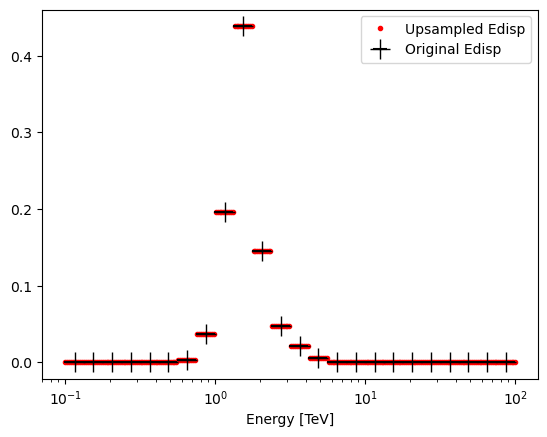

In [30]:
plt.plot(energy_rebins.center, edispKernel_re.data[idx * n_bins],'.',label= "Upsampled Edisp",
        color = 'red')
plt.errorbar(energy.center, edispKernel.data[idx],
            xerr =widths, fmt='+',  label = 'Original Edisp', color = 'black',markersize = 14)
plt.xscale('log')
plt.legend()
plt.xlabel("Energy [TeV]")


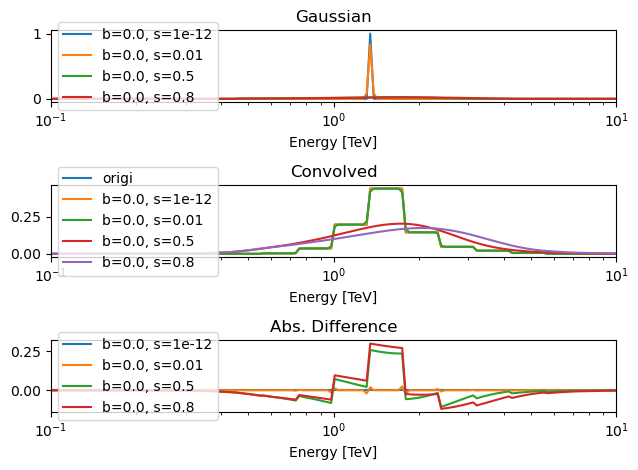

In [31]:
fig, axs = plt.subplots(3,1)
idx_re = idx * n_bins
axs[1].plot(energy_rebins.center ,edispKernel_re.data[idx_re,:], label = 'origi')
for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s,
                                      energy = energy_rebins)
        conv = EDispKernel( axes = edispKernel_re.axes,  data = np.matmul(edispKernel_re.data, gaussian.data))
        axs[0].plot(energy_rebins.center, gaussian.data[idx_re,:], label = f'b={b}, s={s}')
        axs[1].plot(energy_rebins.center , conv.data[idx_re,:],  label = f'b={b}, s={s}')
        axs[2].plot(energy_rebins.center , edispKernel_re.data[idx_re,:]-conv.data[idx_re,:], label = f'b={b}, s={s}')
        
axs[0].set_title("Gaussian")
axs[1].set_title("Convolved")
axs[2].set_title("Abs. Difference")

for a in axs:
    a.legend(loc = 'center left')
    a.set_xlabel("Energy [TeV]")
    a.set_xscale('log')
    a.set_xlim(0.1, 10)
    
plt.tight_layout()

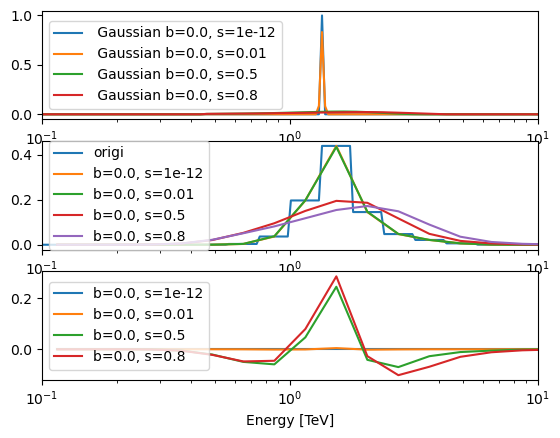

In [32]:
fig, axs = plt.subplots(3,1)
axs[1].plot(energy_rebins.center ,edispKernel_re.data[idx_re,:], label = 'origi')
for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s,
                                      energy = energy_rebins)
        conv = EDispKernel( axes = edispKernel_re.axes,  data = np.matmul(edispKernel_re.data, gaussian.data))
        axs[0].plot(energy_rebins.center, gaussian.data[idx_re,:], label = f' Gaussian b={b}, s={s}')
        axs[1].plot(energy.center , conv.data[idx_re,:].reshape(-1, n_bins).mean(axis=1),
                    label = f'b={b}, s={s}')
        axs[2].plot(energy.center , edispKernel.data[int(idx),:]-conv.data[idx_re,:].reshape(-1, n_bins).mean(axis=1),
                    label = f'b={b}, s={s}')


for a in axs:
    a.legend(loc = 'center left')
    a.set_xlabel("Energy [TeV]")
    a.set_xscale('log')
    a.set_xlim(0.1, 10)